In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt

from datetime import date, timedelta

import numpy as np
import jax.numpy as jnp

import mechafil.data as mecha_data
import mechafil.sim as np_sim
import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C

In [3]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

start_date = date(2023, 6, 1)
current_date = date.today() - timedelta(days=3)
forecast_length = 365*5
end_date = current_date + timedelta(days=forecast_length)

offline_data = data.get_simulation_data(token, start_date, current_date, end_date)

print(start_date, current_date, end_date)

2023-06-01 2023-06-22 2028-06-20


In [4]:
rbp_val = 6
rr_val = 0.6
fpr_val = 0.6
lock_target = 0.3
sector_duration=360

In [5]:
# run numpy simulation
# np_df, np_supply_inputs, np_rb_power_df, np_qa_power_df, np_full_power_df = np_sim.run_simple_sim(
np_df = np_sim.run_simple_sim(
    start_date,
    current_date,
    forecast_length,
    rr_val,
    rbp_val,
    fpr_val,
    sector_duration,
    token
)

In [21]:
# run JAX simulation
rbp = jnp.ones(forecast_length) * rbp_val
rr = jnp.ones(forecast_length) * rr_val
fpr = jnp.ones(forecast_length) * fpr_val

# simulation_results, jax_supply_inputs, jax_rb_power_forecast, jax_qa_power_forecast, jax_power_inputs = sim.run_sim(
simulation_results = sim.run_sim(
    rbp,
    rr,
    fpr,
    lock_target,
    
    start_date,
    current_date,
    forecast_length,
    sector_duration,
    offline_data
)

total_sim_len = (end_date - start_date).days
t = [start_date + timedelta(days=i) for i in range(total_sim_len)]

<IPython.core.display.Javascript object>


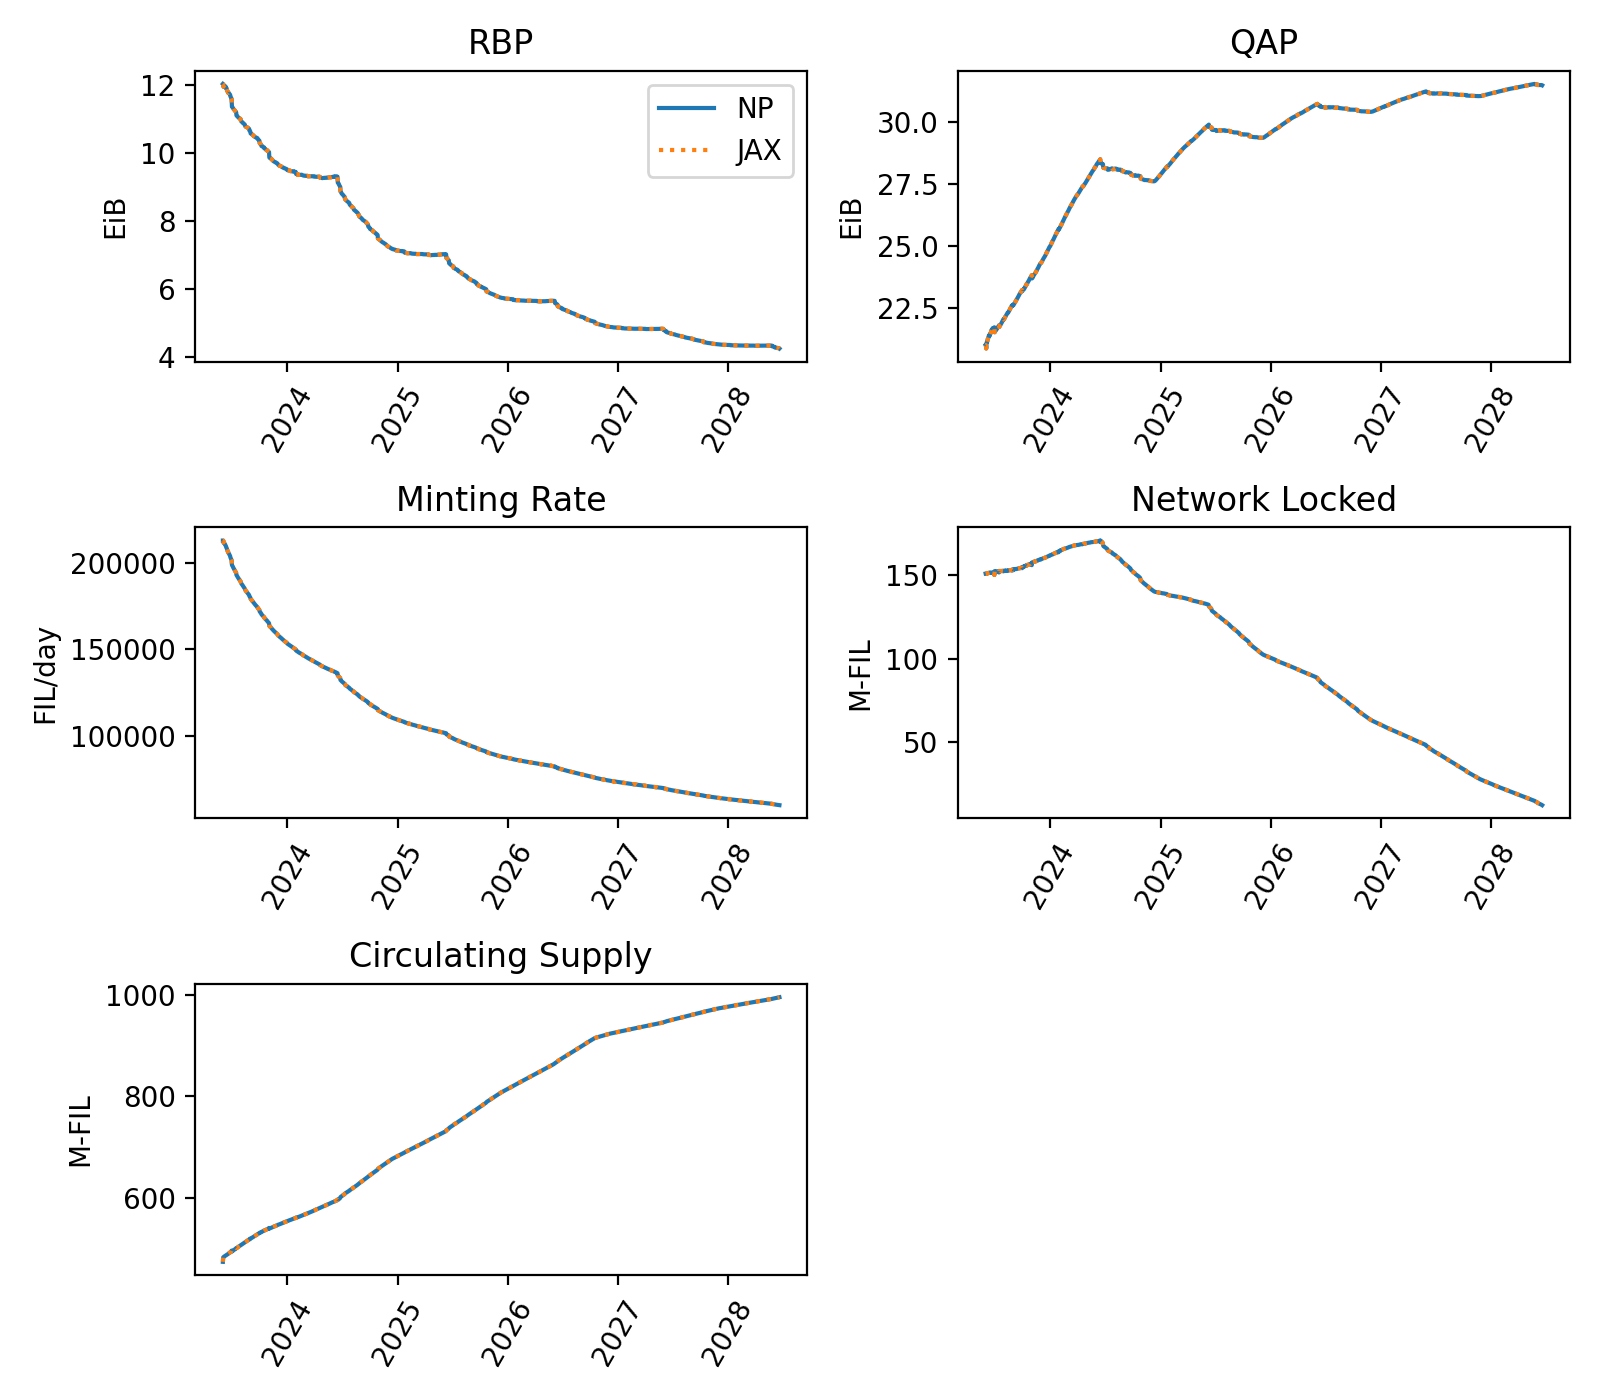

In [22]:
plt.figure(figsize=(8,7))

plt.subplot(3,2,1)
plt.plot(np_df['date'], np_df['network_RBP']/C.EXBI, label='NP')
plt.plot(t, simulation_results['rb_total_power_eib'], label='JAX', linestyle=':')
plt.xticks(rotation=60)
plt.ylabel('EiB')
plt.title('RBP')
plt.legend()

plt.subplot(3,2,2)
plt.plot(np_df['date'], np_df['network_QAP']/C.EXBI, label='NP')
plt.plot(t, simulation_results['qa_total_power_eib'], label='JAX', linestyle=':')
plt.xticks(rotation=60)
plt.ylabel('EiB')
plt.title('QAP')

plt.subplot(3,2,3)
plt.plot(np_df['date'], np_df['day_network_reward'], label='NP')
plt.plot(t, simulation_results['day_network_reward'], label='JAX', linestyle=':')
plt.xticks(rotation=60)
plt.title('Minting Rate')
plt.ylabel('FIL/day')

plt.subplot(3,2,4)
plt.plot(np_df['date'], np_df['network_locked']/1e6, label='NP')
plt.plot(t, simulation_results['network_locked']/1e6, label='JAX', linestyle=':')
plt.xticks(rotation=60)
plt.title('Network Locked')
plt.ylabel('M-FIL')

plt.subplot(3,2,5)
plt.plot(np_df['date'], np_df['circ_supply']/1e6, label='NP')
plt.plot(t, simulation_results['circ_supply']/1e6, label='JAX', linestyle=':')
plt.xticks(rotation=60)
plt.title('Circulating Supply')
plt.ylabel('M-FIL')

plt.tight_layout()

In [8]:
simulation_results['network_locked'].dtype

dtype('float32')

In [9]:
# def ssse(x,y):
#     return np.sqrt(np.sum((x-y)**2))

In [10]:
# # non-vector inputs

# np_keys = ["start_date", "current_date", "end_date", "circ_supply_zero", "locked_fil_zero", "daily_burnt_fil", "duration"]
# jax_keys = ["start_date", "current_date", "end_date", "circ_supply_zero", "locked_fil_zero", "daily_burnt_fil", "duration"]

# for np_key, jax_key in zip(np_keys, jax_keys):
#     npv = np_supply_inputs[np_key]
#     jv = jax_supply_inputs[jax_key]
#     print(npv, jv, npv==jv)

In [11]:
# # check non-df inputs
# npv = np_supply_inputs['renewal_rate_vec']
# jv = jax_supply_inputs['full_renewal_rate_vec']
# print('RR:', ssse(npv, jv))

# npv = np_supply_inputs['burnt_fil_vec']
# jv = jax_supply_inputs['burnt_fil_vec']
# print('BurntFilVec:', ssse(npv, jv))

# npv = np_supply_inputs['known_scheduled_pledge_release_full_vec']
# jv = jax_supply_inputs['known_scheduled_pledge_release_full_vec']
# print('PledgeRelease:', ssse(npv, jv))

In [12]:
# # check vesting
# np_vest = np_supply_inputs['vest_df']
# jax_vest = jax_supply_inputs['vesting_forecast']

# err = ssse(np_vest['total_vest'].values, jax_vest['total_vest'])
# plt.figure(figsize=(4,4))
# plt.plot(np_vest['total_vest'].values - jax_vest['total_vest'])

In [13]:
# # test minting
# np_minting_df = np_supply_inputs['mint_df']
# jax_minting_dict = jax_supply_inputs['minting_forecast']

# mechafil_keys = ['network_baseline', 'cum_capped_power', 'cum_simple_reward', 'cum_baseline_reward', 'cum_network_reward', 'day_network_reward']
# jax_keys = ['network_baseline_EIB', 'cum_capped_power_EIB', 'cum_simple_reward', 'cum_baseline_reward', 'cum_network_reward', 'day_network_reward']
# for k in zip(mechafil_keys, jax_keys):
#     mechafil_key = k[0]
#     jax_key = k[1]

#     y_mechafil = np_minting_df[mechafil_key].values
#     y_jax = jax_minting_dict[jax_key]

#     if 'EIB' in jax_key:
#         y_mechafil = y_mechafil / C.EIB
#     is_close = np.allclose(y_mechafil, y_jax)
#     if not is_close:
#         print('Failed', mechafil_key, ssse(y_mechafil, y_jax))
#     else:
#         print('Passed:', mechafil_key)

In [14]:
# print(len(np_minting_df['network_RBP']), len(jax_minting_dict['network_RBP_EIB']))

In [15]:
# np_minting_df['network_RBP']/C.EIB

In [16]:
# plt.figure()
# x = np_minting_df['network_RBP']/C.EIB
# y = jax_minting_dict['network_RBP_EIB']
# plt.plot(x[1:]-y[0:-1])

In [17]:
# ssse(np_rb_power_df['total_power']/1024.0, jax_rb_power_forecast['total_power']/1024.0)

In [18]:
# ssse(np_rb_power_df['total_power'],jax_rb_power_forecast['total_power'])